<a href="https://colab.research.google.com/github/Polinochka-2/bachelor-s-students-data-analysis/blob/main/DA_HSE_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Итоговый проект: "Приём в магистратуру" 
**Основная задача:** на основе имеющихся данных о бакалаврах (их портфолио и уже известных шансов поступления), которые хотят поступить в магистратуру, предсказать шанс поступления уже для нового набора студентов, которые имеют уже другие баллы за портфолио.

Решение данной задачи **поможет** студентам в составлении списков университетов в соответствии со своим портфолио. Прогнозируемый результат дает им четкое представление об их шансах поступления в магистратуру.

**Работа поделена на 3 части:** <br>
1. Проверка данных на полноту;
2. Исследование взаимосвязей между признаками, чтобы впоследствии построить как можно более точную модель предсказания;
3. Построение модели, которая будет прогнозировать шанс поступления для новых студентов.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import pysubgroup as ps

%matplotlib inline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

from sklearn.pipeline import Pipeline

In [ ]:
#add lables to graphs
def add_labels(label1, label2, label3):
  plt.xlabel(label1)
  plt.ylabel(label2)
  plt.title(label3)

In [ ]:
#find outliers
def find_outlier(df_in, column):
  Q1 = df_in[column].quantile(.25)
  Q3 = df_in[column].quantile(.75)
  IQR = Q3 - Q1
  low = Q1 - 1.5 * IQR
  high = Q3 + 1.5 * IQR
  outlier = df_in.loc[(df_in[column] < low) | (df_in[column] > high)]
  return outlier

In [ ]:
def print_score(y, y_hat, y_valid, y_hat_valid):
    print('Train')
    print('RMSE: \t\t {:04.3f}'.format(sqrt(metrics.mean_squared_error(y, y_hat))))
    print('MSE: \t\t {:04.3f}'.format(metrics.mean_squared_error(y, y_hat)))
    print('\nValidation')
    print('RMSE: \t\t {:04.3f}'.format(sqrt(metrics.mean_squared_error(y_valid, y_hat_valid))))
    print('MSE: \t\t {:04.3f}'.format(metrics.mean_squared_error(y_valid, y_hat_valid)))

Я выбрала [данные, которые содержат в себе информацию о баллах портфолио каждого бакалавра, поступающего в магистратуру (всего 500 поступающих)](https://www.kaggle.com/mohansacharya/graduate-admissions/version/2#): <br>
- **GRE Score (Graduate Record Examinations)** - экзамен по английскому языку, который обычно требуется для поступления на магистерские и докторские программы. GRE Score $\in [0, 340] \subset Z$.<br>
- **TOEFL Score (Test of English as a Foreign Language)** - международный экзамен по английскому языку. TOEFL Score $\in [0, 120] \subset Z$.<br>
- **University Rating** - рейтинг университета, куда студент хочет поступить в магистратуру. Может принимать следующие значения: $1, 2, 3, 4, 5$, где 5 - самый высокий рейтинг.<br>
- **SOP (Statement of Purpose)** - вступительное эссе. SOP $\in [1, 5]$.<br>
- **LOR (Letter of Recommendation)** - рекомендательное письмо. LOR $\in [1, 5]$.<br>
- **CGPA (Undergraduate GPA)** - средний балл бакалавриата. CGPA $\in [0, 10]$.<br>
- **Research** - наличие исследовательского опыта. Принимает значения: 0 или 1.<br>
- **Chance of Admit** - шанс поступления в магистратуру. Chance of Admit $\in [0, 1]$, где 0 - вообще нет шанса поступить, а 1 - 100% вероятность поступить в магистратуру с данным портфолио. 

In [ ]:
data_full = pd.read_csv('Admission_Predict_Ver1.1.csv').drop(columns='Serial No.')
data_full.tail()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73
499,327,113,4,4.5,4.5,9.04,0,0.84


# 1. Исследуем наши данные: тип переменных, наличие / отсутствие пропусков, выбросы

## Тип переменных:

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


То есть текстовых переменных у нас нет, что значительно упрощает работу.

## Наличие / отсутствие пропусков в данных:

In [ ]:
data_full.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

То есть пропусков в данных нет.

## Проверяем на наличие выбросов:

**Таким образом**, из графиков можно увидеть, что в переменных "LOR" и "Chance of Admit" есть выбросы. 

**Является ли такое отклонение выбросом?** Я бы посчитала, что нет. Действительно, эти значения не попадают в границы по критерию Тьюки, но области определения они соответствуют, и если посмотреть на эти экземпляры "целиком", они не кажутся сверх необычными. Например, 2 человека с низким Chance of Admit действительно имеют немного ниже баллы за экзамены и другие вступительные испытания, так что нет ничего удивительного в том, что значения Chance of Admit тоже немного ниже.

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
347,299,94,1,1.0,1.0,7.34,0,0.42


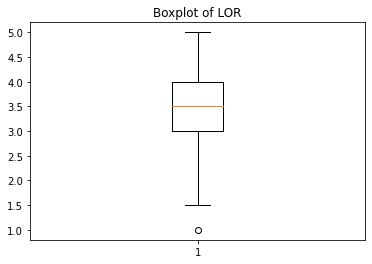

In [ ]:
plt.boxplot(data_full['LOR ']);
plt.title('Boxplot of LOR')
outliers_LOR = find_outlier(data_full, 'LOR ')
outliers_LOR

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
92,298,98,2,4.0,3.0,8.03,0,0.34
376,297,96,2,2.5,2.0,7.43,0,0.34


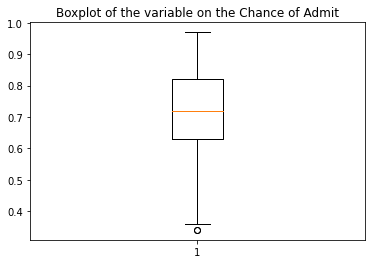

In [ ]:
plt.boxplot(data_full['Chance of Admit ']);
plt.title('Boxplot of the variable on the Сhance of Admit')
outliers_Chance = find_outlier(data_full, 'Chance of Admit ')
outliers_Chance

# 2. Исследование взаимосвязей между переменными

### Распределение Chance of Admit в зависимости от рейтинга университета:

Видно, что кроме того, что средние значения Chance of Admit тем выше, чем выше рейтинг, кроме того вид распределений тоже различный. Например, для рейтинга 5 длинный хвост справа (то есть большинство студентов из таких университетов имеют высокие шансы поступления в магистратуру), а для рейтинга 1 - слева (то есть многие студенты из низкорейтинговых университетов скорее имеют низкий шанс поступления. Но эта взаимосвязь не такая яркая, как с рейтингом 5).

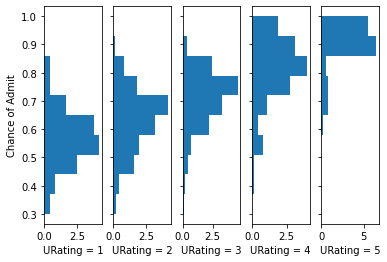

In [ ]:
# общая ось y
fig, axes = plt.subplots(ncols = 5, sharey = True)

for i in range(1, 6):
    mask = data_full['University Rating'] == i
    axes[i - 1].hist(data_full.loc[mask, 'Chance of Admit '], range = (0.3, 1),
            orientation = 'horizontal', density = True);
    axes[i - 1].set_xlabel('URating = {:01}'.format(i))
plt.setp(axes[0], ylabel='Chance of Admit');

Среднее значение Chance of Admit тем выше, чем выше рейтинг университета. Наибольшая дисперсия характерна для университета с рейтингом 2. А для 1 и 5, напротив, распределения самые "компактные". <br>
Это значит, что у студентов из университетов с рейтингом 2 есть те, у кого и низкий шанс поступления, а есть те, у кого и высокий. То есть в этой группе нельзя проследить четкой взаимосвязи.

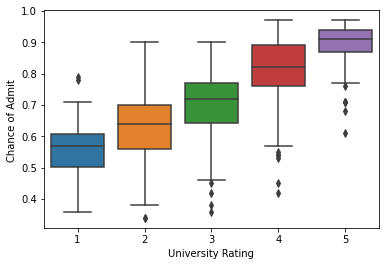

In [ ]:
sns.boxplot(x='University Rating', y = 'Chance of Admit ', data = data_full);

Видно, что для высоких значений Chance of Admit характерны высокие значения рейтинга университета ($\geqslant 3$), а во всем датасете распределение почти симметрично.

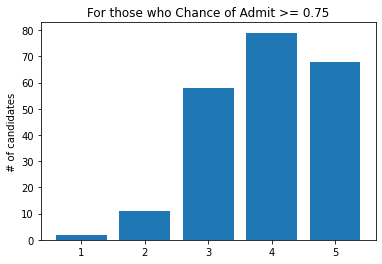

In [ ]:
high_prob = data_full['Chance of Admit '] >= 0.75
df_high = data_full.loc[high_prob]
df_grouped = df_high.groupby('University Rating').size()
plt.bar(df_grouped.index, df_grouped.values)
plt.ylabel('# of candidates');
plt.title('For those who Chance of Admit >= 0.75');

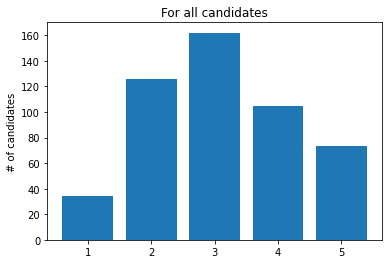

In [ ]:
df_grouped = data_full.groupby('University Rating').size()
plt.bar(df_grouped.index, df_grouped.values)
plt.ylabel('# of candidates')
plt.title('For all candidates');

Видно, если Research == 1, значения GRE Score и Chance of Admit выше, когда GRE Score > 300. Это можно увидеть и из расположения точек, и из наклона прямых.

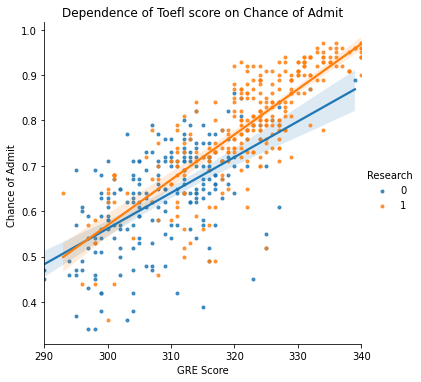

In [ ]:
sns.lmplot(x = 'GRE Score', y = 'Chance of Admit ', data=data_full, hue = 'Research', markers = '.');
plt.title('Dependence of Toefl score on Chance of Admit');

Визуализация трехмерной зависимости. Видно, что существует линейная связь между CGPA, GRE Score и рейтингом университета: чем выше оценки за экзамены, тем выше и рейтинг.

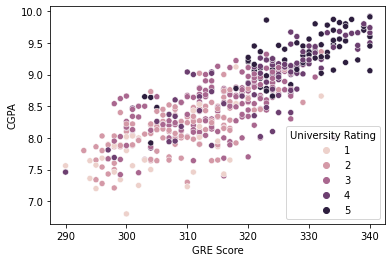

In [ ]:
mask = data_full.columns == 'University Rating'
sns.scatterplot(x = 'GRE Score', y = 'CGPA', hue = 'University Rating', data = data_full, legend = 'full');

**Дисперсия неоднородная:** она значительно больше для наблюдений с низкими значениями признаков. Это значит, что среди студентов с низким баллом GRE есть те, кто имеет как хороший шанс поступления, а есть те, у кого он низкий. <br>
Однако при GRE Score > 320 разброс маленький, что говорит о том, что у студентов с высоким баллом GRE, высокий шанс поступления. 

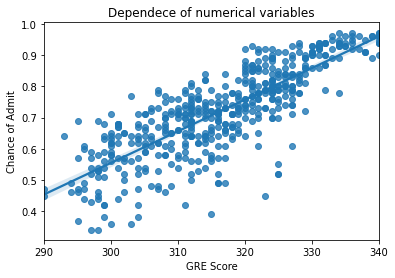

In [ ]:
sns.regplot(x = 'GRE Score', y = 'Chance of Admit ', data=data_full);
add_labels('GRE Score', 'Chance of Admit', 'Dependece of numerical variables')

График показывает, что между переменными CGPA и Chance of Admit существует линейная взаимосвязь.

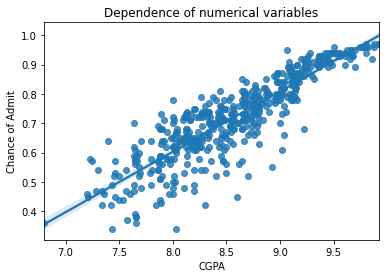

In [ ]:
sns.regplot(x = 'CGPA', y = 'Chance of Admit ', data = data_full)
add_labels('CGPA','Chance of Admit','Dependence of numerical variables');


Тут важно заметить, что вообще все переменные между собой коррелируют. Даже бинарная переменная Research имеет довольно высокую корреляцию с переменными (>0.4). 

Однако самая сильная взаимосвязь прослеживается между CGPA и Chance of Admit. Далее идут GRE и TOEFL Score.

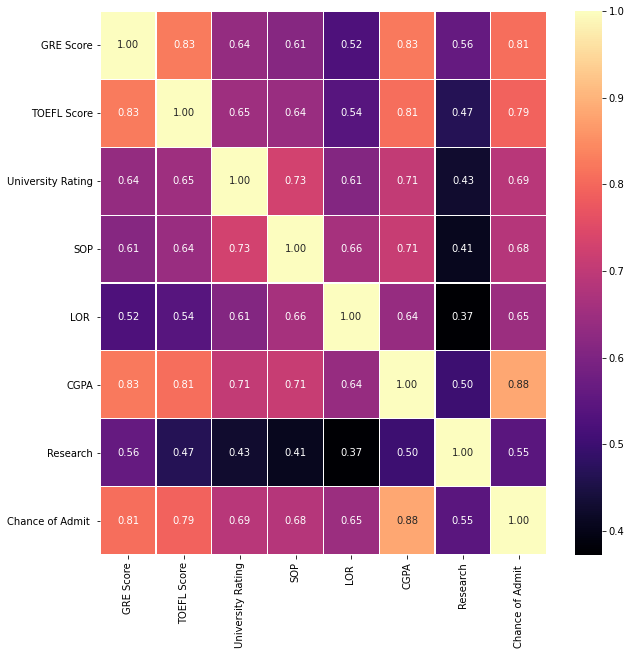

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(data_full.corr(), annot = True, linewidth = 0.05, fmt = '.2f', cmap = 'magma');

## Распределение переменных

### Проверяем на нормальность переменную CGPA:

Сначала проверим на нормальность переменные CGPA, GRE Store, TOEFL Score, Chance of Admit, чтобы в дальнейшем применить подходящие статистические методы для определения взаимосвязей признаков между собой.

**Критерий Пирсона:**

**Нулевая гипотеза $H_0$**: выборка извлечена из нормально распределенной генеральной совокупности

**Альтернативная гипотеза $H_1$**: выборка извлечена из генеральной совокупности, которая не является нормально распределенной

Далее при проверки переменных на нормальность использются эти же гипотезы.

In [ ]:
w1, p_value1 = stat.normaltest(data_full['CGPA'])
alpha = .05
if p_value1 < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.4f}'.format(p_value1))
else:
    print('Нет оснований отвергнуть нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.4f}'.format(p_value1))

Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value =  0.0018


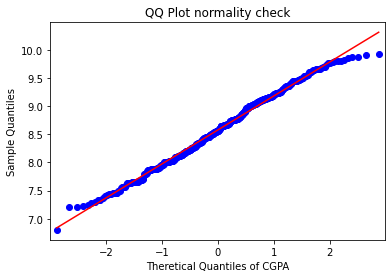

In [ ]:
qqplot(data_full['CGPA'], line='s')
add_labels('Theretical Quantiles of CGPA', 'Sample Quantiles', 'QQ Plot normality check')

**Вывод:** проверив распределение переменной **CGPA**, убедились, что она не является нормально распределенной.

### Проверяем на нормальность переменную GRE Score:

Используем критерий Пирсона и qq-plot.

In [ ]:
w2, p_value2 = stat.normaltest(data_full['GRE Score'])
alpha = .05
if p_value2 < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value2))
else:
    print('Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value2))

Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value =  0.0000


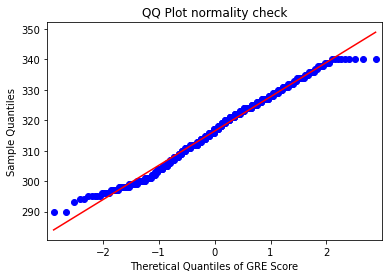

In [ ]:
qqplot(data_full['GRE Score'], line='s')
add_labels('Theretical Quantiles of GRE Score', 'Sample Quantiles', 'QQ Plot normality check')

**Вывод:** проверив распределение переменной **GRE Score**, убедились, что она не является нормально распределенной.

### Проверяем на нормальность переменную TOEFL Score:

Используем критерий Пирсона и qq-plot.

In [ ]:
w3, p_value3 = stat.normaltest(data_full['TOEFL Score'])
alpha = .05
if p_value3 < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value3))
else:
    print('Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value3))

Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value =  0.0000


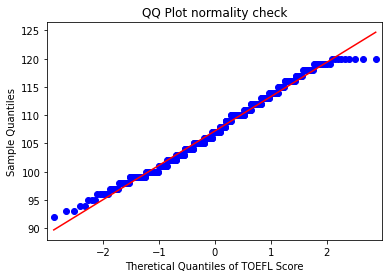

In [ ]:
qqplot(data_full['TOEFL Score'], line='s')
add_labels('Theretical Quantiles of TOEFL Score', 'Sample Quantiles', 'QQ Plot normality check')

**Вывод:** проверив распределение переменной **GRE Score**, убедились, что она не является нормально распределенной.

### Проверяем на нормальность переменную Chance of Admit:

Используем критерий Пирсона и qq-plot.

In [ ]:
w4, p_value4 = stat.normaltest(data_full['Chance of Admit '])
alpha = .05
if p_value4 < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value4))
else:
    print('Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value4))

Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value =  0.0010


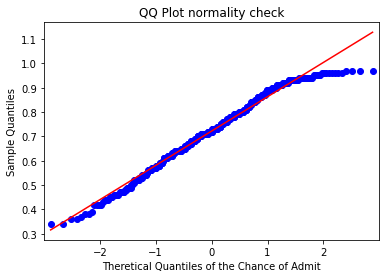

In [ ]:
qqplot(data_full['Chance of Admit '], line='s')
add_labels('Theretical Quantiles of the Chance of Admit', 'Sample Quantiles', 'QQ Plot normality check')

**Вывод:** проверив распределение переменной **Chance of Admit**, убедились, что она не является нормально распределенной.

Это может быть связано с тем, что у нас мало данных.

Таким образом, поскольку переменные CGPA, GRE Score, TOEFL Score и Chance of Admit не являются нормально распределенными, в дальнейшем используем критерии Краскелла-Уоллиса и Манна-Уитни для анализа взаимосвязей между переменными.

### Критерии однородности:

**Рассмотрим взаимосвязь переменной GRE Score при наличии и отсутствии исследования (Research)**

In [ ]:
mask1 = data_full['Research'] == 1
mask0 = data_full['Research'] == 0

GRE1 = data_full.loc[mask1, 'GRE Score']
GRE0 = data_full.loc[mask0, 'GRE Score']

GRE1_mean = np.mean(GRE1)
GRE0_mean = np.mean(GRE0)

print('Выборочное среднее GRE при наличии Research = ', GRE1_mean)
print('Выборочное среднее GRE при отсутствии Research = ', GRE0_mean)

GRE1_var = np.var(GRE1)
GRE0_var = np.var(GRE0)

print('\n')
print('Выборочная дисперсия GRE при наличии Research = ', GRE1_var)
print('Выборочная дисперсия GRE при отсутствии Research = ', GRE0_var)



Выборочное среднее GRE при наличии Research =  322.10714285714283
Выборочное среднее GRE при отсутствии Research =  309.3


Выборочная дисперсия GRE при наличии Research =  97.55994897959174
Выборочная дисперсия GRE при отсутствии Research =  73.35545454545449


**Критерий Краскелла-Уоллиса, проверка на равенство медиан:** поскольку данные не являются нормально распределенными, то применяем данный метод.

$H_0$- медианы совпадают <br>
$H_1$- медианы различны. <br>
Далее при рассмотрении других переменных гипотезы такие же.

Если же распределение является нормальным, то медиана совпадает со средним $\to$ этими гипотезами можем сравнить средние. 

Поэтому проведем преобразование Бокса-Кокса, чтобы данные стали нормально распределенными.

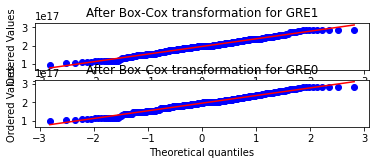

In [ ]:
GRE1_box, _ = stat.boxcox(GRE1)
GRE0_box, _ = stat.boxcox(GRE0)
fig = plt.figure()
ax3 = fig.add_subplot(413)
prob = stat.probplot(GRE1_box, dist=stat.norm,plot=ax3)
ax3.set_title('After Box-Cox transformation for GRE1');
ax4 = fig.add_subplot(414)
prob=stat.probplot(GRE1_box, dist=stat.norm,plot=ax4)
ax4.set_title('After Box-Cox transformation for GRE0');

Проверим, выполняются ли гипотезы нормальности распределения теперь. 

In [ ]:
w, p_value = stat.normaltest(GRE1_box)
alpha = .05
if p_value < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value))
else:
    print('Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value))

Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value =  0.6060


In [ ]:
w, p_value = stat.normaltest(GRE0_box)
alpha = .05
if p_value < alpha:
    print('Отклоняем нулевую гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value))
else:
    print('Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value = ', '{:05.04f}'.format(p_value))

Нет оснований отклонить гипотезу о том, что распределение нормальное, p-value =  0.4131


**Таким образом, получили нормально распределенную переменную.**

Теперь применяем **критерий Краскелла-Уоллиса**, где медиана уже совпадает со средним.

In [ ]:
print('Размер эффекта: ',
      np.mean(GRE1_box) - np.mean(GRE0_box))

Размер эффекта:  1.9546986491743754e+17


In [ ]:
st, pvalue = stat.kruskal(GRE1_box, GRE0_box)
alpha = .05
if pvalue < alpha:
    print('Отклоняем нулевую гипотезу, то есть медианы различны')
else:
    print('Нет оснований отклонить нулевую гипотезу, то есть медианы совпадают')

Отклоняем нулевую гипотезу, то есть медианы различны


**Вывод:** две группы, GRE Score с Research=1 и GRE с Research=0, имеют различные медианы, а следовательно, и средние. То есть в среднем баллы GRE Score статистически различимы при наличии и отсутствии исследования (с исследованием больше). Иными словами, разница в баллах GRE при наличии и отсутствии исследования статистически значима.


**Критерий Фишера:**

Изначальная переменная не является нормально распределенной, но после преобразования Бокса-Кокса, это изменилось. Поэтому можно применить критерий Фишера о равенстве дисперсий. 

In [ ]:
print('Размер эффекта: ',
      np.var(GRE1_box) - np.var(GRE0_box))

Размер эффекта:  1.706919273437905e+33


In [ ]:
left = stat.f.ppf(alpha / 2, len(pd.DataFrame(GRE1_box).index) - 1,len(pd.DataFrame(GRE0_box).index) - 1)
right = stat.f.ppf(1 - alpha / 2,len(pd.DataFrame(GRE1_box).index) - 1,len(pd.DataFrame(GRE0_box).index) - 1)
print(left)
print(right)

0.7796525301179443
1.2875566602647799


In [ ]:
statistics = np.var(GRE1_box) / np.var(GRE0_box)
if (statistics>right) |(statistics<left):
    print('Отклоняем нулевую гипотезу, то есть дисперсии различны')
else:
    print('Нет оснований отклонить нулевую гипотезу, то есть дисперсии совпадают')

Отклоняем нулевую гипотезу, то есть дисперсии различны


**Вывод:** дисперсии двух групп, GRE Score при Research=1 и GRE Score при Research=0, различны. То есть в подгруппе, где студенты имеют исследование, мы имеем более разнообразную публику, чем там, где у студентов исследования нет.

**Критерий Манна-Уитни:** проверяем являются ли распределения в двух рассматриваемых группах одинаковыми.

Необходимое условие критерия выполнено, то есть количество наблюдений $> 20$.

А, например, необходимое условие критерия Вилкоксона о том, что размерности двух групп совпадают, не выполнено, поэтому его применить не можем.

In [ ]:
st,p_value = stat.mannwhitneyu(GRE1_box, y=GRE0_box)
alpha = .05
if p_value < alpha:
    print('Отклоняем нулевую гипотезу, то есть распределения различны')
else:
    print('Нет оснований отклонить нулевую гипотезу, то есть распределения совпадают')

Отклоняем нулевую гипотезу, то есть распределения различны


**Вывод:** распределения в группах GRE Score при Research = 1 и GRE Score при Research = 0 различны. То есть баллы за GRE Score при наличии и отсутствии исследования статистически различны. Иными словами, если в портфолио есть информация об исследованиях, то это повышает шанс поступления (поскольку при наличии исследования балл GRE в среднем выше, а если балл GRE выше, то и шанс поступления больше, так как с шансом поступления GRE образует линейную зависимость).

Аналогичные результаты были при рассмотрении двух групп с наличием и отсутствием исследования для признаков CGPA, GRE Score, TOEFL Score, Chance of Admit.

Поэтому отсюда можно заключить, что интересно было бы построить модель предсказания по отдельности для тех, у кого есть исследования и у кого нет. 



## Subgroup Discovery

Также интересно выявить группы, которые отличаются с точки зрения шанса поступления, и понять, какие у них характеристики. 

Целевая переменная:

In [ ]:
target = ps.NumericTarget('Chance of Admit ')

Пространство поиска групп:

In [ ]:
searchspace = ps.create_selectors(data_full, ignore=['Chance of Admit '])

In [ ]:
task = ps.SubgroupDiscoveryTask (
data_full,
target,
searchspace,
result_set_size=5,
depth=2, 
qf=ps.StandardQFNumeric(a = 1)) 

result = ps.BeamSearch().execute(task)
result.to_dataframe()

,quality,subgroup,size_sg,size_dataset,mean_sg,mean_dataset,std_sg,std_dataset,median_sg,median_dataset,max_sg,max_dataset,min_sg,min_dataset,mean_lift,median_lift
0,19.10280,Research==1,280.0,500.0,0.789964,0.72174,0.122988,0.140999,0.80,0.72,0.97,0.97,0.36,0.34,1.094528,1.111111
1,18.48426,CGPA>=9.13,101.0,500.0,0.904752,0.72174,0.048187,0.140999,0.91,0.72,0.97,0.97,0.68,0.34,1.253571,1.263889
2,18.07122,CGPA>=9.13 AND Research==1,97.0,500.0,0.908041,0.72174,0.045558,0.140999,0.92,0.72,0.97,0.97,0.68,0.34,1.258128,1.277778
3,17.06426,TOEFL Score>=113,101.0,500.0,0.890693,0.72174,0.066886,0.140999,0.91,0.72,0.97,0.97,0.61,0.34,1.234091,1.263889
4,16.73600,GRE Score>=327,100.0,500.0,0.889100,0.72174,0.069081,0.140999,0.91,0.72,0.97,0.97,0.61,0.34,1.231884,1.263889


Объединяя студентов лишь по наличию исследования, получаем достаточно большую группу. Ранее было продемонстрировано, что эта группа статистически различима с той, где отсутствует исследование. Несмотря на то, что в этой группе 280 студентов из 497 и шанс поступления в среднем = 0.78, шанс поступления колеблется от 0.36 до 0.97, что охватывает почти все возможные значения.


## Зависимость категориальных переменных University Rating  и Chance of Admit (разбиваем на категории в зависимости от величины)

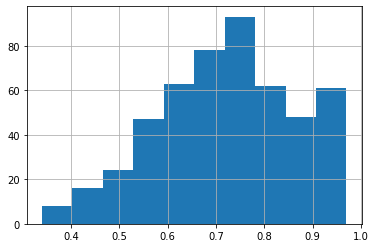

In [ ]:
data_full['Chance of Admit '].hist();

Делаем переменную категориальной

In [ ]:
data_cat = data_full.copy()
data_cat.loc[data_full['Chance of Admit '] < .5, 'Chance of Admit '] = 0
data_cat.loc[data_full['Chance of Admit '] > .7, 'Chance of Admit '] = 2
data_cat.loc[(data_full['Chance of Admit '] >= .5) & (data_cat['Chance of Admit '] <= .7) , 'Chance of Admit '] = 1

data_cat.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,2.0
1,324,107,4,4.0,4.5,8.87,1,2.0
2,316,104,3,3.0,3.5,8.00,1,2.0
3,322,110,3,3.5,2.5,8.67,1,2.0
4,314,103,2,2.0,3.0,8.21,0,1.0


**Критерий $\chi^2$**:

$H_0$ - категориальные переменные независимы <br>
$H_1$ - категориальные переменные зависимы. <br>
На вход должна подаваться таблица сопряженности двух рассматриваемых величин.

Преобразуем эти две переменные в массив:

In [ ]:
table = data_cat[['University Rating', 'Chance of Admit ']].values

#построение таблицы сопряженности
df_new=data_cat.groupby(['University Rating','Chance of Admit ']).size().to_frame().unstack()


#заполняем NaN нулем, чтобы в дальнейшем применить критерий хи квадрат
df_new=df_new.fillna(0)
df_new

0            
Chance of Admit     0.0   1.0   2.0
University Rating                  
1                   8.0  23.0   3.0
2                  20.0  76.0  30.0
3                   7.0  60.0  95.0
4                   2.0  15.0  88.0
5                   0.0   2.0  71.0

In [ ]:
stat1, p1, dof, expected = stat.chi2_contingency(df_new)
if p1 < alpha:
    print('Отклоняем нулевую гипотезу о том, что переменные независимы, p-value = ', '{:05.4f}'.format(p1))
else:
    print('Нет оснований отклонить нулевую гипотезу о том, что переменные независимы, p-value = ', '{:05.4f}'.format(p1))

Отклоняем нулевую гипотезу о том, что переменные независимы, p-value =  0.0000


In [ ]:
expected

array([[ 2.516, 11.968, 19.516],
       [ 9.324, 44.352, 72.324],
       [11.988, 57.024, 92.988],
       [ 7.77 , 36.96 , 60.27 ],
       [ 5.402, 25.696, 41.902]])

**Вывод:** переменные University Rating и Chance of Admit являются взаимосвязанными. Это можно заметить, если сравнить df_new c ожидаемыми частотами expected. 

То есть между рейтингом университета и шансом поступления существует взаимосвязь. То есть проанализировав таблицу сопряженности, мы можем понять, что чем выше рейтинг университета, тем больше шанс поступления у студента.

# 3. Построение модели, которая будет прогнозировать шанс поступления для новых студентов

**Разделяем на тренировочную и тестовую выборки**

In [ ]:
is_target = data_full.columns == 'Chance of Admit '
X, X_valid, y, y_valid = train_test_split(data_full.loc[:, ~is_target], data_full.loc[:, is_target], test_size=0.08, random_state=42)

In [ ]:
y = y.values.ravel()
y_valid = y_valid.values.ravel()

**Выводы с предыдущих этапов:**

Распределение Chance of Admit похоже на бимодальное:
- первая мода около 0.75
- вторая мода около 1

Наблюдается почти линейная зависимость с целевой переменной Chance of Admit:
1. GRE
2. TOEFL
3. CGPA <br>
Наибольшая линейная зависимость с CGPA. 

Взаимосвязь с категориальными признаками:
1. Research. Распределения раззличны в группах у:
    * GRE
    * TOEFL
    * CGPA
    
    Целевая группа имеет более высокое среднее в группе, где Research = 1.
2. Chance of Admit. Наблюдаем увеличение среднего целевой переменной с увеличением рейтинга. 




## Feature importance

Будем использовать F-тест и взаимную информацию.

Они здесь показывают примерно одно и то же, наибольшая линейная зависимость с CGPA.

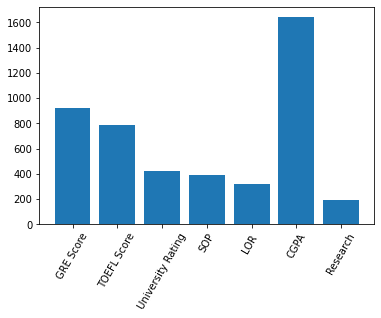

In [ ]:
f_stats, p_values = f_regression(X,y)

plt.bar(X.columns.values, f_stats)
plt.xticks(rotation=60);

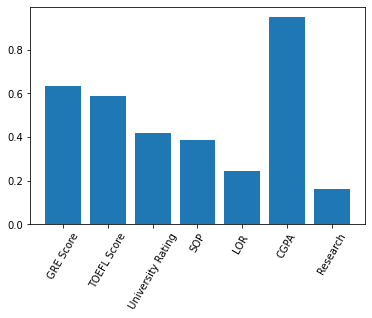

In [ ]:
m_info = mutual_info_regression(X,y)

plt.bar(X.columns.values, m_info)
plt.xticks(rotation=60);

## Простая модель, построенная с помощью линейной регрессии (MSE: 0.004, 0.006)

Построим модель только на одном признаке, так как корреляция с CGPA сильная. Значит и модель будет неплохая. Буду использовать pipeline (можно представить, как набор инструкций). 

Перед построением модели проводим стандартизацию. Преобразование категориальных признаков здесь не требуется, так как Research - уже бинарная переменная, а для University Rating отношение порядка имеет смысл, так что его можно оставить в численном виде.

In [ ]:
model = linear_model.LinearRegression

steps = [('scaler', StandardScaler()),
        ('select_features', SelectKBest(f_regression, k=1)),
        ('linear_reg', model())]

pipeline = Pipeline(steps)
pipeline.fit(X[['CGPA']], y)
y_hat = pipeline.predict(X[['CGPA']])

y_hat_valid = pipeline.predict(X_valid[['CGPA']])

In [ ]:
print_score(y, y_hat, y_valid, y_hat_valid)

Train
RMSE: 		 0.066
MSE: 		 0.004

Validation
RMSE: 		 0.075
MSE: 		 0.006


В нашем случае ошибка приемлемая.

## Модель с k лучшими признаками

Здесь нужно будет подобрать гиперпараметр k. Так как вариантов перебора немного, будем использовать GridSearch. Так как набор данных небольшой, будем использовать разбиение на 10 фолдов для подбора k.

In [ ]:
steps = [('scaler', StandardScaler()),
        ('select_features', SelectKBest(f_regression)),
        ('linear_reg', model())]

grid_params = {
    'select_features__k': range(1, 8)
}

pipeline_kbest = Pipeline(steps)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

clf = GridSearchCV(pipeline_kbest, grid_params, scoring='neg_mean_squared_error', cv=cv, return_train_score=True)
clf.fit(X, y);

In [ ]:
print('Best Score (MSE): ', -clf.best_score_)
print('Best Params (number of features): ', clf.best_params_)

Best Score (MSE):  0.0035344616410626166
Best Params (number of features):  {'select_features__k': 7}


Хоть и GridSearch выдает мне в качестве наилучшей модели модель, которая включает все признаки, можно заметить, что именно у этой модели один из самых больших разрывов между оценками на тесте и трейне, а самый маленький - у модели с одним признаком. Это нужно взять на заметку как первый симптом переобучения (в случае включения всех признаков).

In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] -  result_cv['mean_train_score']
result_cv.sort_values(by=['diff_score'], ascending=True)

,params,mean_train_score,mean_test_score,diff_score
0,{'select_features__k': 1},0.004298,0.004333,0.000035
1,{'select_features__k': 2},0.003820,0.003868,0.000048
2,{'select_features__k': 3},0.003708,0.003771,0.000063
4,{'select_features__k': 5},0.003603,0.003699,0.000095
5,{'select_features__k': 6},0.003485,0.003604,0.000119
6,{'select_features__k': 7},0.003408,0.003534,0.000127
3,{'select_features__k': 4},0.003625,0.003757,0.000132


## Заново построим модель, теперь уже с заданным гиперпараметром (MSE: 0.003, 0.005)

In [ ]:
steps = [('scaler', StandardScaler()),
        ('linear_reg', model())]

pipeline_allfeat = Pipeline(steps)
pipeline_allfeat.fit(X, y)
y_hat = pipeline_allfeat.predict(X)

y_hat_valid = pipeline_allfeat.predict(X_valid)

print_score(y, y_hat, y_valid, y_hat_valid)

Train
RMSE: 		 0.058
MSE: 		 0.003

Validation
RMSE: 		 0.071
MSE: 		 0.005


Модель стала немного лучше, чем раньше. Сократилась ошибка MSE. Это в принципе объяснимо, так как в предыдущей модели мы использовали только один признак, а тут все (7). 

Добавим регуляризацию, вероятно, она снизит разницу между тренировочными и тестовыми данными. 

## Модель с elastic-net

In [ ]:
en_model = linear_model.ElasticNet

steps = [('scaler', StandardScaler()), 
         ('en_linear_reg', en_model())]

grid_params = {
  'en_linear_reg__alpha': [0, 0.5] + [5**x for x in np.linspace(0, 2, 20)], 
  'en_linear_reg__l1_ratio':   np.linspace(0, 1, 11)
}

pipeline_en = Pipeline(steps)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

clf = GridSearchCV(pipeline_en, grid_params, scoring='neg_mean_squared_error', cv=cv, return_train_score=True)
clf.fit(X, y);

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7044394844697813, tolerance: 0.0007838991304347826
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_

In [ ]:
print('Best Score (MSE): ', -clf.best_score_)
print('Best Params (elastic net): ', clf.best_params_)

Best Score (MSE):  0.0035344616410626166
Best Params (elastic net):  {'en_linear_reg__alpha': 0, 'en_linear_reg__l1_ratio': 0.0}


In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['param_en_linear_reg__alpha',
                                                    'param_en_linear_reg__l1_ratio',
                                                    'mean_train_score',
                                                    'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] - result_cv['mean_train_score']
result_cv[result_cv.param_en_linear_reg__alpha >= 1]

,param_en_linear_reg__alpha,param_en_linear_reg__l1_ratio,mean_train_score,mean_test_score,diff_score
22,1,0,0.004316,0.004381,0.000065
23,1,0.1,0.016381,0.016549,0.000168
24,1,0.2,0.019704,0.019819,0.000114
25,1,0.3,0.019704,0.019819,0.000114
26,1,0.4,0.019704,0.019819,0.000114
...,...,...,...,...,...
237,25,0.6,0.019704,0.019819,0.000114
238,25,0.7,0.019704,0.019819,0.000114
239,25,0.8,0.019704,0.019819,0.000114
240,25,0.9,0.019704,0.019819,0.000114


Наилучшей согласно GridSearch является модель без регуляризации, то есть ничего не изменилось.

**Вывод:** Таким образом, проведя регуляризацию, мы получили, что наименьшая ошибка получается при ее отсутствии. 

Также можем сделать вывод, что более точное предсказание нам дает модель, построенная по всем признакам. Ошибки MSE на тренировочной выборке составляют 0.003, а на тестовой - 0.005 соответственно.

## Модель для групп с наличием/отсутствием Research

In [ ]:
print(X.Research.value_counts())
print(X_valid.Research.value_counts())

1    254
0    206
Name: Research, dtype: int64
1    26
0    14
Name: Research, dtype: int64


In [ ]:
mask_has_research = X.Research == 1
mask_has_research_valid = X_valid.Research == 1

Повторим построение модели с Elastic Net, но теперь для двух групп раздельно.

### Студенты с наличием Research

In [ ]:
clf.fit(X.loc[mask_has_research ], y[mask_has_research]);

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26929992316291423, tolerance: 0.00036393473684210535
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model

In [ ]:
print('Группа студентов с наличием Research: ')
print('Best Score (MSE): ', -clf.best_score_)
print('Best Params (elastic net): ', clf.best_params_)

Группа студентов с наличием Research: 
Best Score (MSE):  0.002480634631770235
Best Params (elastic net):  {'en_linear_reg__alpha': 0, 'en_linear_reg__l1_ratio': 0.0}


In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['param_en_linear_reg__alpha', 
                                                     'param_en_linear_reg__l1_ratio', 
                                                     'mean_train_score', 
                                                     'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] -  result_cv['mean_train_score']
result_cv

,param_en_linear_reg__alpha,param_en_linear_reg__l1_ratio,mean_train_score,mean_test_score,diff_score
0,0,0,0.002363,0.002481,0.000118
1,0,0.1,0.002363,0.002481,0.000118
2,0,0.2,0.002363,0.002481,0.000118
3,0,0.3,0.002363,0.002481,0.000118
4,0,0.4,0.002363,0.002481,0.000118
...,...,...,...,...,...
237,25,0.6,0.015244,0.015347,0.000103
238,25,0.7,0.015244,0.015347,0.000103
239,25,0.8,0.015244,0.015347,0.000103
240,25,0.9,0.015244,0.015347,0.000103


### Студенты без Research

In [ ]:
clf.fit(X[~mask_has_research], y[~mask_has_research]);

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41287786374978486, tolerance: 0.00023332345945945954
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model

In [ ]:
print('Группа студентов без Research: ')
print('Best score (MSE): ', -clf.best_score_)
print('Best Params (elastic net): ', clf.best_params_)

Группа студентов без Research: 
Best score (MSE):  0.004901683930299087
Best Params (elastic net):  {'en_linear_reg__alpha': 0, 'en_linear_reg__l1_ratio': 0.0}


In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['param_en_linear_reg__alpha', 
                                                     'param_en_linear_reg__l1_ratio', 
                                                     'mean_train_score', 
                                                     'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] -  result_cv['mean_train_score']
result_cv

,param_en_linear_reg__alpha,param_en_linear_reg__l1_ratio,mean_train_score,mean_test_score,diff_score
0,0,0,0.004601,0.004902,0.000301
1,0,0.1,0.004601,0.004902,0.000301
2,0,0.2,0.004601,0.004902,0.000301
3,0,0.3,0.004601,0.004902,0.000301
4,0,0.4,0.004601,0.004902,0.000301
...,...,...,...,...,...
237,25,0.6,0.012220,0.012307,0.000087
238,25,0.7,0.012220,0.012307,0.000087
239,25,0.8,0.012220,0.012307,0.000087
240,25,0.9,0.012220,0.012307,0.000087


Посмотрим, что будет на тестовой выборке, будем использовать обычную регрессию без регуляризации (так как при gridsearch именно такая модель оказалась оптимальной, и регуляризация в нашем случае не сокращает разрыв в ошибках на train и test).

In [ ]:
print('\tStudents with Research: ')
pipeline_allfeat.fit(X[mask_has_research ], y[mask_has_research ])
y_hat = pipeline_allfeat.predict(X[mask_has_research ])

y_hat_valid = pipeline_allfeat.predict(X_valid[mask_has_research_valid])
print_score(y[mask_has_research], y_hat, y_valid[mask_has_research_valid], y_hat_valid)

print('\n\n\tStudents without Research: ')
pipeline_allfeat.fit(X[~mask_has_research ], y[~mask_has_research ])
y_hat = pipeline_allfeat.predict(X[~mask_has_research ])

y_hat_valid = pipeline_allfeat.predict(X_valid[~mask_has_research_valid])
print_score(y[~mask_has_research ], y_hat ,y_valid[~mask_has_research_valid], y_hat_valid)

	Students with Research: 
Train
RMSE: 		 0.049
MSE: 		 0.002

Validation
RMSE: 		 0.054
MSE: 		 0.003


	Students without Research: 
Train
RMSE: 		 0.068
MSE: 		 0.005

Validation
RMSE: 		 0.094
MSE: 		 0.009


Так как вторая модель работает хуже, чем предыдущие попытки, я проверю, какую ошибку получаем для студентов c и без исследования в последней наилучшей модели, обучающейся на всех студентах.

In [ ]:
# the last best model
steps = [('scaler', StandardScaler()), 
         ('linear_reg', model())]

pipeline_allfeat = Pipeline(steps)
pipeline_allfeat.fit(X, y)

print('\tMSE For simple regression on all features')
print('\tfor students with research\n')
y_hat = pipeline_allfeat.predict(X)

y_hat_valid = pipeline_allfeat.predict(X_valid)
print_score(y[mask_has_research], y_hat[mask_has_research] ,y_valid[mask_has_research_valid], y_hat_valid[mask_has_research_valid])

print('\n\n\tMSE For simple regression on all features')
print('\tfor students without research\n')
print_score(y[~mask_has_research], y_hat[~mask_has_research], y_valid[~mask_has_research_valid], y_hat_valid[~mask_has_research_valid])

	MSE For simple regression on all features
	for students with research

Train
RMSE: 		 0.049
MSE: 		 0.002

Validation
RMSE: 		 0.055
MSE: 		 0.003


	MSE For simple regression on all features
	for students without research

Train
RMSE: 		 0.068
MSE: 		 0.005

Validation
RMSE: 		 0.094
MSE: 		 0.009


Видим, что ошибки в этих двух группах идентичны.

На данный момент, считаю простую регрессию на всех признаках наилучшей моделью.

## Исследование ошибок модели (простой регрессии)

Сделаю визуализацию ошибок, это даст понять, куда двигаться дальше, чтобы улучшить модель.

Среднее ошибки близко 0 $\rightarrow$ здесь все в порядке.


In [ ]:
e = y - y_hat

In [ ]:
np.mean(e)

6.202767768014461e-17

**Ошибки VS Целевая переменная**

Однозначно не наблюдается однородная дисперсия у ошибок.

1. Когда целевая переменная переоценена (e < 0), абсолютные значения ошибок выше при y < 0.7
2. Меньше всего дисперсия при y близких к 1.

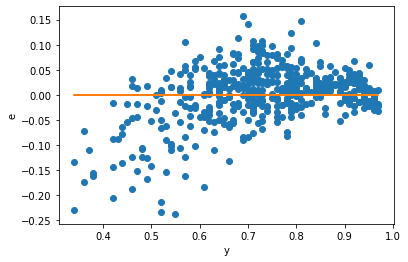

In [ ]:
plt.plot(y, e, 'o')
plt.plot(y, np.zeros(len(y)), '-')
plt.xlabel('y')
plt.ylabel('e');

**Ошибки VS Признаки**

Можно заметить, что для университетов со средним рейтингом целевая переменная часто переоценена, а с рейтингом 1 и 5 - наоборот.

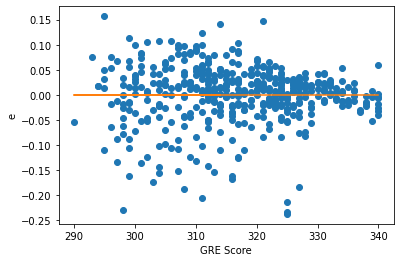

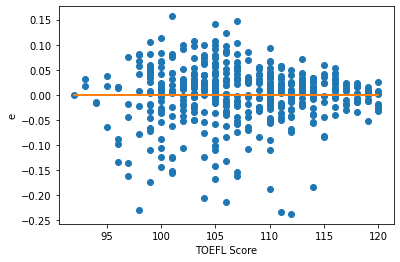

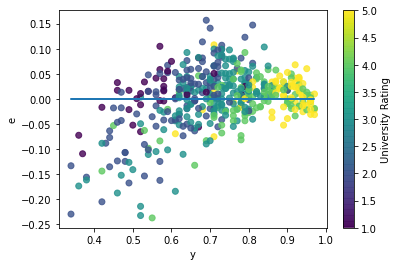

Средняя ошибка по группам:
University Rating
1    0.009858
2   -0.000468
3   -0.001701
4   -0.006309
5    0.008515
Name: e, dtype: float64
Средняя абсолютная ошибка по группам:
University Rating
1    0.035787
2    0.056969
3    0.044974
4    0.032449
5    0.025866
Name: e, dtype: float64


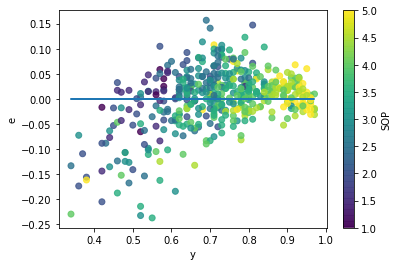

Средняя ошибка по группам:
SOP
1.0    0.008139
1.5   -0.003272
2.0   -0.003642
2.5    0.009531
3.0    0.000320
3.5   -0.004697
4.0   -0.004217
4.5   -0.001114
5.0    0.009617
Name: e, dtype: float64
Средняя абсолютная ошибка по группам:
SOP
1.0    0.035639
1.5    0.037082
2.0    0.061074
2.5    0.052092
3.0    0.048589
3.5    0.045644
4.0    0.034255
4.5    0.028190
5.0    0.028232
Name: e, dtype: float64


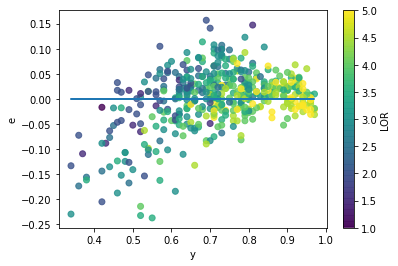

Средняя ошибка по группам:
LOR 
1.0   -0.016881
1.5   -0.016762
2.0    0.001167
2.5    0.010114
3.0   -0.002423
3.5   -0.001119
4.0    0.000693
4.5   -0.004064
5.0    0.003528
Name: e, dtype: float64
Средняя абсолютная ошибка по группам:
LOR 
1.0    0.016881
1.5    0.059127
2.0    0.053471
2.5    0.056629
3.0    0.052043
3.5    0.044219
4.0    0.034752
4.5    0.029324
5.0    0.020664
Name: e, dtype: float64


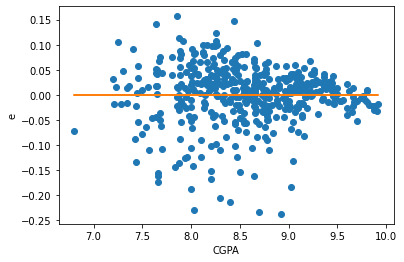

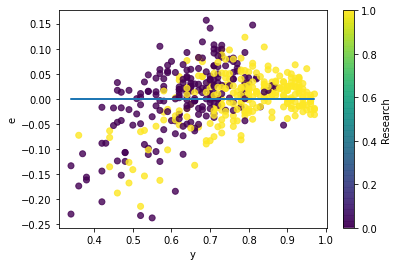

Средняя ошибка по группам:
Research
0   -6.386477e-17
1    1.641294e-16
Name: e, dtype: float64
Средняя абсолютная ошибка по группам:
Research
0    0.050027
1    0.035416
Name: e, dtype: float64


In [ ]:
for col in X.columns:
    
    if col in ['University Rating', 'Research', 'LOR ', 'SOP']:
        plt.scatter(x=y, y=e, c=X[col], alpha=0.8)
        plt.plot(y, np.zeros(len(y)), '-')
        plt.xlabel('y')
        plt.ylabel('e')
        cbar = plt.colorbar()
        cbar.set_label(col)
        plt.show()
        print('Средняя ошибка по группам:')
        print(pd.DataFrame({'e': e, col: X[col].values}).groupby(col)['e'].mean())
        
        print('Средняя абсолютная ошибка по группам:')
        print(pd.DataFrame({'e': np.abs(e), col: X[col].values}).groupby(col)['e'].mean())
    else:
        plt.plot(X[col], e, 'o')
        plt.plot(X[col], np.zeros(len(y)), '-')
        plt.xlabel(col)
        plt.ylabel('e')
        plt.show()

Ошибка неоднородна в первую очередь по целевой переменной, значит у нас не хватает информации. Я попробую разделить данные на 2 группы по рейтингу университета.

## Модель для групп по рейтингу университета

Группы с рейтингом 1 и 5 - самые малочисленные. Вероятно столкнемся с недообучением.

In [ ]:
print(X['University Rating'].value_counts())
print(X_valid['University Rating'].value_counts())

3    146
2    118
4     95
5     69
1     32
Name: University Rating, dtype: int64
3    16
4    10
2     8
5     4
1     2
Name: University Rating, dtype: int64


In [ ]:
mask_rat15 = (X['University Rating'] == 1) | (X['University Rating'] == 5)
mask_rat15_valid = (X_valid['University Rating'] == 1) | (X_valid['University Rating'] == 5)

**Студенты из университетов с рейтингом 1 или 5**

In [ ]:
clf.fit(X.loc[mask_rat15], y[mask_rat15]);

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056365260549407145, tolerance: 0.0002721512222222223
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model

In [ ]:
print('Group of students from Universities with Rating 1 or 5:')
print("Best Score (MSE): ", -clf.best_score_)
print("Best Params (elastic net): ", clf.best_params_)

Group of students from Universities with Rating 1 or 5:
Best Score (MSE):  0.0016686159049354333
Best Params (elastic net):  {'en_linear_reg__alpha': 0, 'en_linear_reg__l1_ratio': 0.0}


In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['param_en_linear_reg__alpha', 
                                                     'param_en_linear_reg__l1_ratio', 
                                                     'mean_train_score', 
                                                     'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] -  result_cv['mean_train_score']
result_cv

,param_en_linear_reg__alpha,param_en_linear_reg__l1_ratio,mean_train_score,mean_test_score,diff_score
0,0,0,0.001166,0.001669,0.000502
1,0,0.1,0.001166,0.001669,0.000502
2,0,0.2,0.001166,0.001669,0.000502
3,0,0.3,0.001166,0.001669,0.000502
4,0,0.4,0.001166,0.001669,0.000502
...,...,...,...,...,...
237,25,0.6,0.029533,0.030547,0.001014
238,25,0.7,0.029533,0.030547,0.001014
239,25,0.8,0.029533,0.030547,0.001014
240,25,0.9,0.029533,0.030547,0.001014


**Студенты из университетов с рейтингом 2, 3, 4**

In [ ]:
clf.fit(X.loc[~mask_rat15], y[~mask_rat15]);

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6457135237889031, tolerance: 0.0004979634055727554
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_

In [ ]:
print('Group of students who have research:')
print("Best Score (MSE): ", -clf.best_score_)
print("Best Params (elastic net): ", clf.best_params_)

Group of students who have research:
Best Score (MSE):  0.0041998439273780355
Best Params (elastic net):  {'en_linear_reg__alpha': 0, 'en_linear_reg__l1_ratio': 0.0}


In [ ]:
result_cv = pd.DataFrame.from_dict(clf.cv_results_)[['param_en_linear_reg__alpha', 
                                                     'param_en_linear_reg__l1_ratio', 
                                                     'mean_train_score', 
                                                     'mean_test_score']]
result_cv[['mean_train_score', 'mean_test_score']] = result_cv[['mean_train_score', 'mean_test_score']] * (-1)
result_cv.loc[:, 'diff_score'] = result_cv['mean_test_score'] -  result_cv['mean_train_score']
result_cv

,param_en_linear_reg__alpha,param_en_linear_reg__l1_ratio,mean_train_score,mean_test_score,diff_score
0,0,0,0.003944,0.004200,0.000256
1,0,0.1,0.003944,0.004200,0.000256
2,0,0.2,0.003944,0.004200,0.000256
3,0,0.3,0.003944,0.004200,0.000256
4,0,0.4,0.003944,0.004200,0.000256
...,...,...,...,...,...
237,25,0.6,0.015614,0.015667,0.000053
238,25,0.7,0.015614,0.015667,0.000053
239,25,0.8,0.015614,0.015667,0.000053
240,25,0.9,0.015614,0.015667,0.000053


Модель не стала лучше, в простой линейно регрессии были примерно такие же ошибки **в этих подгруппах**.

В итоге, здесь мы остановились на том, что самая простая модель линейной регрессии на всех признаках оказалась наилучшей.

Однако в предыдущих работах было построено еще две ансамблевые модели с такой же ошибкой: 
- ансамбль методом бэггинга из линейных регрессий по всем признакам
- Adaboost, где в качестве основы использовалась линейная регрессия.

Так как ошибка у них такая же, А регрессионная модель является более простой и интерпретируемой, то именно ее поэтому выбираем в качестве окончательной модели.

## Еще раз изучим модель, которую считаем наилучшей, чтобы убедиться, что она не нарушает "логики" предметной области. 

In [ ]:
steps = [('scaler', StandardScaler()), 
         ('linear_reg', model())]

pipeline_allfeat = Pipeline(steps)
pipeline_allfeat.fit(X, y)
y_hat = pipeline_allfeat.predict(X)

y_hat_valid = pipeline_allfeat.predict(X_valid)
print_score(y, y_hat, y_valid, y_hat_valid)

print('\n \t Coefficients:')
coef = pipeline_allfeat.named_steps['linear_reg'].coef_
coef = pd.DataFrame({'names': X.columns, 'coef': coef})
coef.reindex(coef.coef.abs().sort_values().index)

Train
RMSE: 		 0.058
MSE: 		 0.003

Validation
RMSE: 		 0.071
MSE: 		 0.005

 	 Coefficients:


,names,coef
3,SOP,0.001961
2,University Rating,0.006294
6,Research,0.010751
4,LOR,0.015032
1,TOEFL Score,0.017572
0,GRE Score,0.023351
5,CGPA,0.069928


Видим, что коэффициенты модели "адекватные". Как и ожидали, наибольший вклад вносит CGPA, а далее, GRE Score, TOEFL Score. Все коэффициенты положительные, что согласуется со здравым смыслом, так как чем выше оценки за экзамены, тесты и т.д., тем больше шанс быть принятым.

Интересно посмотреть, что покажет для итоговой модели описательная регрессия.

In [ ]:
X0 = sm.add_constant(X)

smm = sm.OLS(y, X0)
res = smm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     308.2
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          1.22e-167
Time:                        17:22:41   Log-Likelihood:                 653.65
No. Observations:                 460   AIC:                            -1291.
Df Residuals:                     452   BIC:                            -1258.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.3309      0.109    -12.174      0.000      -1.546      -1.116
GRE Score             0.0021      0.001      3.993      0.000       0.001       0.003
TOEFL Score           0.0029      0.001      3.260      0.001       0.001       0.005
University Rating     0.0055      0.004      1.411      0.159      -0.002       0.013
SOP                   0.0020      0.005      0.426      0.671      -0.007       0.011
LOR                   0.0162      0.004      3.845      0.000       0.008       0.024
CGPA                  0.1156      0.010     11.732      0.000       0.096       0.135
Research              0.0216      0.007      3.185      0.002       0.008       0.035
==============================================================================
Omnibus:                       94.053   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.474
Skew:                          -1.076   Prob(JB):                     6.55e-45
Kurtosis:                       5.447   Cond. No.                     1.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

По результатам можно сказать, что два признака считаются незначимыми в нашей модели: University Rating и SOP. Действительно, например, между SOP и LOR существует довольно сильная корреляция, 0.66. Можно полагать, что достаточно и одного признака. Однако при добавлении обоих признаков ошибка предсказания уменьшается, то есть модель лучше. Аналогичная ситуация в University Rating, её добавление улучшает предсказательную способность модели.

Наибольший вклад, как и отмечалось ранее, тут вносит CGPA, однако затем идут Research, LOR. А только потом TOEFL и GRE Scores. Стоит отметить, что добавление каждого признака в модель улучшает ее, а не ухудшает, поэтому было принято решение выбрать модель на всех признаках.

# Итоги:



В данной работе было проделано следующее: <br>
1. Был проведен анализ взаимосвязей признаков между собой. Выявлено, что все переменные довольно-таки сильно коррелируют между собой. Однако, переменная CGPA больше всех взаимосвязана с Chance of Admit. Также был выявлен интересный факт, который дал нам идею для построения модели для двух групп студентов: у которых был предыдущий опыт исследования и у которых его не было.
2. Была построена модель с ошибкой MSE = 0.005 на тестовой выборке и = 0.003 - на тренировочной, которая по новым портфолио студентов сможет предсказывать их шанс поступления. Эта модель **поможет** студентам в составлении списков университетов в соответствии со своим портфолио. Прогнозируемый результат дает им четкое представление об их шансах поступления в магистратуру.
3. Анализ самой модели показал, что не только CGPA сильно влияет на шанс поступления, но и также результаты GRE и TOEFL. Несмотря на то, что признаки University Rating и SOP показались незначимыми в описательной регрессии, они все равно улучшают модель.